# Project Overview

## Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#Importing all the required libraries
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
import sys
print(sys.version)

3.6.10 |Anaconda custom (64-bit)| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]


# Problem Statement

1) Determine which demographic groups, i.e.age, gender and income groups, respond best to the offer types. 

2) Assess characteristics of the demographic group that do not respond to offers.

3) Build a model that predicts whether or not someone will respond to an offer. 

# Metrics
Business question 3 is a classification problem. Hence, Accuracy and F1-scire Metrics will be used to to measure performance of the models.

# 1. Data Exploration

### 1.1 Loading the datasets

In [4]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [6]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


Let's determine the shape of our datasets.

In [7]:
portfolio.shape

(10, 6)

In [8]:
transcript.shape

(306534, 4)

In [9]:
profile.shape

(17000, 5)

In [10]:
#baseline descriptive statistics for the numerical variables in the data
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [11]:
#baseline descriptive statistics for the numerical variables in the data
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
#baseline descriptive statistics for the numerical variables in the data
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# 2. Data Preprocessing
The next steps is data cleaning i.e dealing with missing values, duplicates, create dummies for categorical variables and datatype tranformation

In [13]:
#For cleaning the portfolio dataset, we have to take the following steps below:

# Change the name of the 'id' column to 'offerid'
portfolio.rename(columns={"id": "offerid"}, inplace = True)

# One-Hot encode the 'channels' columns
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1

#transform offer duration days to hours
portfolio['duration']=portfolio['duration']*24


# Drop the "channels" column
portfolio = portfolio.drop(columns=['channels'])

portfolio.head(10)

,reward,difficulty,duration,offer_type,offerid,web,email,mobile,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [14]:
#Check for missing values in the dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   offerid     10 non-null     object
 5   web         10 non-null     int32 
 6   email       10 non-null     int32 
 7   mobile      10 non-null     int32 
 8   social      10 non-null     int32 
dtypes: int32(4), int64(3), object(2)
memory usage: 688.0+ bytes


There are no missing values in the portfolio dataset. Next, we move on to cleaning other datasets.

In [15]:
#Check for missing values in the dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


There are the same amount of missing values for gender and income in the profile dataset.Let's explore this further to determine if we will impute a mean/ median or remove the missing values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023960B955C0>,
      dtype=object)

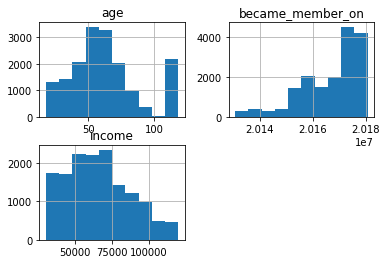

In [16]:
#Run some data exploration to understand the profile data
profile.hist()

Age has an outlier in the histogram distribution. let's explore this further.

In [17]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

The maximum age is 118 which is not realistic. Let us check what are the values for Gender and Income, when age is 118

In [18]:
#checking the values for gender and income when age=118
profile[['gender','income','age']][profile['age']==118].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


In [19]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [20]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The missing values for age and gender is equal to the value counts when age is 118. Could there be a connection between these three variables. Let's examine the values of income and gender when age is 118.

In [21]:
#Check when age is 118 and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


Yes, there is a connection. This means that if we remove all the values when age is 118, then there will be no missing values for gender and income. we shall begin the cleaning process for the profile dataset.

In [22]:
#For cleaning the profile dataset, we have to take the following steps below:
# Change the name of the id column to customerid
profile.rename(columns={"id": "customerid"}, inplace = True)

# Convert missing value encoded as 118 to N/A in the age column
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

# drop all missing values
profile.dropna(inplace=True)
profile = profile.reset_index(drop=True)

# extract the year that users became members and number of days since the user signed up using the current day as reference
profile['start_year'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year
profile['membership_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['membership_days'] = profile['membership_days'].dt.days
profile = profile.drop(columns=['became_member_on'])


profile.head()

,gender,age,customerid,income,start_year,membership_days
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1065
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1132
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,780
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,856
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,946


In [23]:
#updated number of columns and rows after removing age= 118
profile.shape

(14825, 6)

In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There are no missing values in the transcript dataset.

In [40]:
#For cleaning the transcript dataset, we have to take the following steps below:
# Change the name of the 'person' column to 'customerid'

transcript.rename(columns={"person": "customerid"}, inplace = True)

# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customerid'].isin(profile['customerid'])]

#Expand the value column to create offer_id, amount and reward columns
transcript =pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript = transcript.drop(columns=['value'])


transcript = transcript.reset_index(drop=True)
transcript.head(10)

,customerid,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


We have to further clean the transcript dataset because it has two offer id columns.

In [41]:
#combine the 2 offer id columns into one using the def function
def merge_cols(row):
    if pd.isnull(row['offer id']):
        val = row['offer_id']
    else:
        val = row['offer id']
    return val

#Applying the function to create offer_id_nw column
transcript['offer_id_new'] = transcript.apply(merge_cols, axis=1)
transcript.head(10)

,customerid,event,time,offer id,amount,offer_id,reward,offer_id_new
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [42]:
#Dropping offer id and offer_id column
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
#Renaming offer_id_new column to offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [43]:
transcript.head(10)

,customerid,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,31dda685af34476cad5bc968bdb01c53,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,f806632c011441378d4646567f357a21,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


# 3. Data Visualization
## 3a. Visualization of the profile data
The next step is to visualize the data after cleaning

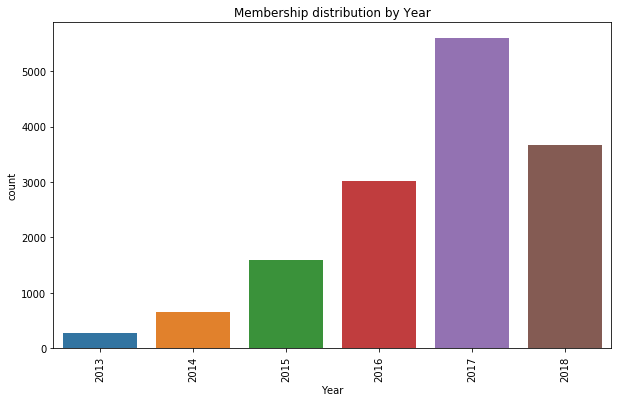

In [31]:
#Plotting membership distribution
plt.figure(figsize=(10, 6))
sns.countplot(profile['start_year'])
plt.title('Membership distribution by Year')
plt.xlabel('Year')
plt.xticks(rotation = 90)
plt.show();

2017 was the year where most of the app users became members while 2013 was the year with the least members.

Text(0.5,1,'Gender distribution by members')

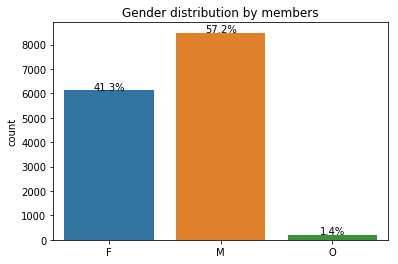

In [33]:
#Plotting Gender distribution
ax = sns.countplot(x="gender", data=profile)
total = float(len(profile))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
    
ax.set_xlabel('')
ax.set_ylabel('count')
ax.set_title('Gender distribution by members')

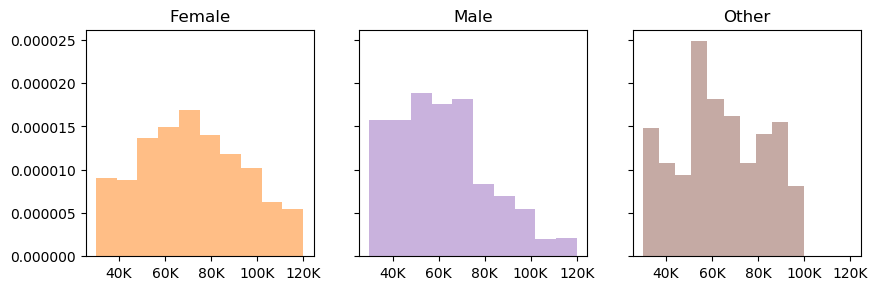

In [35]:
#Creating a function to format of income labels into ranges
def income(x, position):
    'The two args are the value and tick position'
    return '{:1.0f}K'.format(x*1e-3)

#creating a function to change the gender labels
def labels(gender): 
    if gender == "M": 
        label = 'Male'
    elif gender == "F": 
        label = 'Female'
    else: 
        label ='Other'
    return label

#Gender distribution by income 
fig, axes = plt.subplots(1, 3, figsize=(10,3), dpi=100, sharex=True, sharey=True)
colors = ['tab:orange', 'tab:purple', 'tab:brown']

for i, (ax, gender) in enumerate(zip(axes.flatten(), profile.gender.unique())):
    x = profile.loc[profile.gender==gender, 'income']
    ax.xaxis.set_major_formatter(plt.FuncFormatter(income))
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True, label=str(gender), color=colors[i])
    ax.set_title(labels(gender))

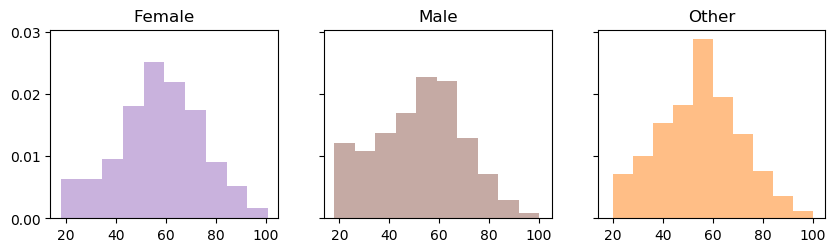

In [36]:
#Gender Distribution by age
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:purple', 'tab:brown', 'tab:orange']
for i, (ax, gender) in enumerate(zip(axes.flatten(), profile.gender.unique())):
    x = profile.loc[profile.gender==gender, 'age']
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True,  color=colors[i])
    ax.set_title(labels(gender))


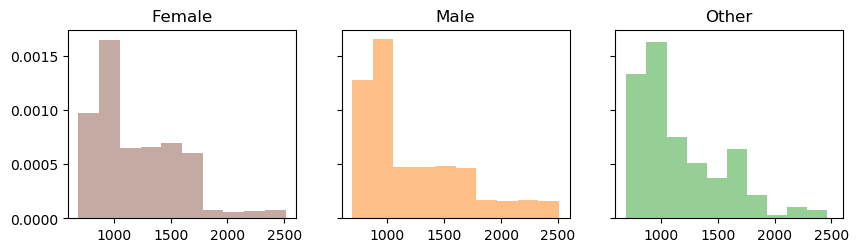

In [37]:
#Gender distribution by membership days
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:brown', 'tab:orange', 'tab:green']
for i, (ax, gender) in enumerate(zip(axes.flatten(), profile.gender.unique())):
    x = profile.loc[profile.gender==gender, 'membership_days']
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True,  color=colors[i])
    ax.set_title(labels(gender))

## 3b. Visualization of the Transcript data

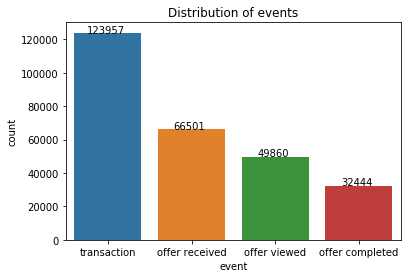

In [44]:
#bar chart distribution of event
ax = sns.countplot(transcript['event'], 
                   order = transcript['event'].value_counts().index)
for p, label in zip(ax.patches, transcript['event'].value_counts().values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15),ha = 'center')
    ax.set_title('Distribution of events')

Text(0.5,1,'Offer_ids with Completed Status')

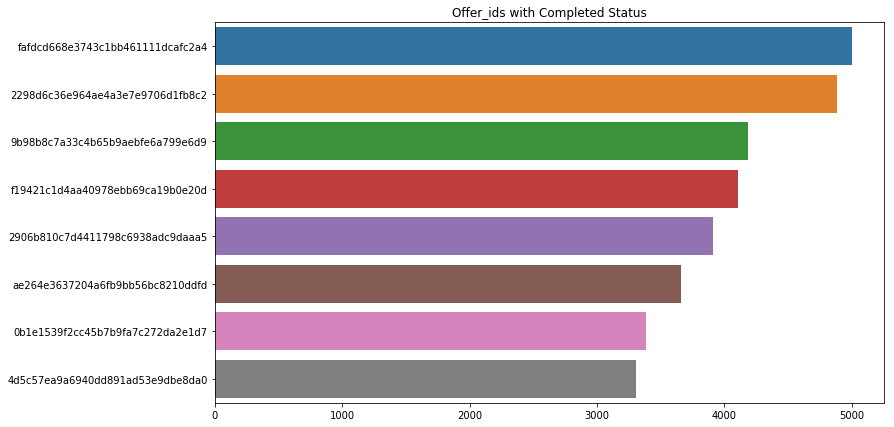

In [46]:
#check offer_ids that were completed
completed_offers = transcript[transcript['event']=='offer completed']
completed_offers['offer_id'].value_counts()
#plot a bar chart to show the distribution
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=completed_offers, order = completed_offers['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids with Completed Status')

From the graph, we see that offer id 'fafdcd668e3743c1bb461111dcafc2a4' has the highest completed status while offer id '4d5c57ea9a6940dd891ad53e9dbe8da0' has the lowest completed status.

Text(0.5,1,'Offer_ids Received by Starbucks App Users')

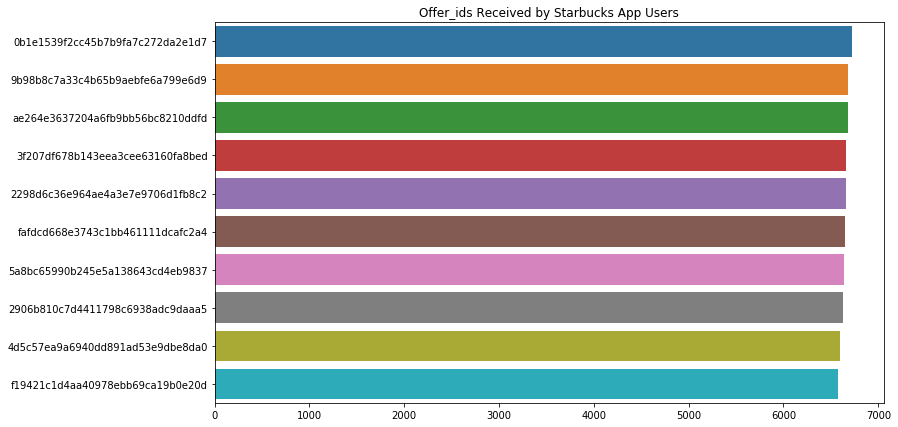

In [48]:
#count offer_ids that were received
received_offers = transcript[transcript['event']=='offer received']
received_offers['offer_id'].value_counts()
#plot the distribution of offer_ids received
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=received_offers, order = received_offers['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids Received by Starbucks App Users')

From the graph, we see that offer id '0b1e1539f2cc45b7b9fa7c272da2e1d7' has the highest received status while offer id 'f19421c1d4aa40978ebb69ca19b0e20d' has the lowest received status.

Text(0.5,1,'Offer_ids Viewed by Starbucks App Users')

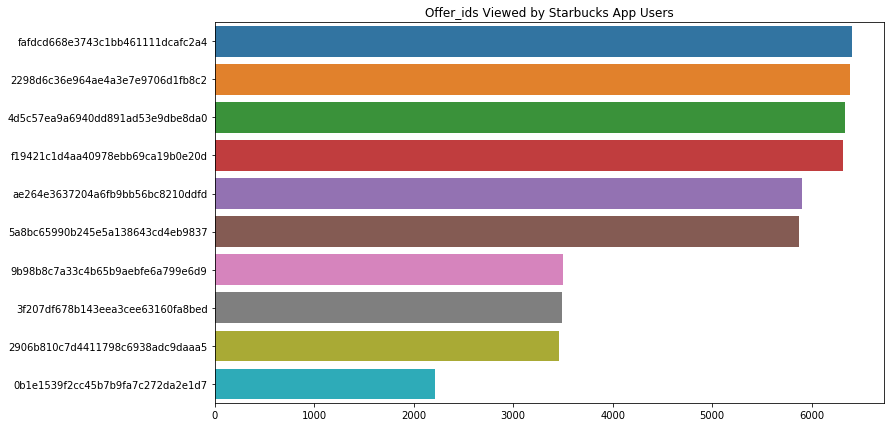

In [49]:
#count offer_ids that were viewed
viewed_offers = transcript[transcript['event']=='offer viewed']
viewed_offers['offer_id'].value_counts()
#plot the distribution of offer_ids viewed
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=viewed_offers, order = viewed_offers['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids Viewed by Starbucks App Users')

From the graph, we see that offer id 'fafdcd668e3743c1bb461111dcafc2a4' has the highest viewed status while offer id '0b1e1539f2cc45b7b9fa7c272da2e1d7' has the lowest viewed status.

'fafdcd668e3743c1bb461111dcafc2a4'was a popular offer id for Starbucks users.In the next few codes, we shall examine its offer type by combining the portfolio and profile data to achieve this. 

## 3c. Merging the three datasets

In [52]:
starbucks_dataset = transcript.merge(portfolio,how='left',on='offer_id')
starbucks_dataset.head(10)

KeyError: 'offer_id'

In [ ]:
transcript['offer_id'] = 'fafdcd668e3743c1bb461111dcafc2a4'
transcript.head()